In [1]:
from google.colab import files
import zipfile, os, shutil

print("UPLOAD EXACTLY TWO ZIP FILES: Class 0 and Class 1")
uploaded = files.upload()

file_names = list(uploaded.keys())
print("\nUploaded files:", file_names)


print("\nChoose which zip is Class 0:")
for i, f in enumerate(file_names):
    print(f"{i}: {f}")

choice0 = int(input("Enter number for CLASS 0 ZIP: "))
choice1 = 1 - choice0

# For personal understanding only

zip0 = file_names[choice0]
zip1 = file_names[choice1]

print("\nSelected:")
print("Class 0 =", zip0)
print("Class 1 =", zip1)

# Create folders
root = "/content/data"
class0_dir = os.path.join(root, "Class0")
class1_dir = os.path.join(root, "Class1")
os.makedirs(class0_dir, exist_ok=True)
os.makedirs(class1_dir, exist_ok=True)

def extract_flat(zip_path, target_dir):
    with zipfile.ZipFile(zip_path, "r") as z:
        for item in z.namelist():
            if item.endswith("/"):
                continue
            filename = os.path.basename(item)
            if filename == "":
                continue
            dest = os.path.join(target_dir, filename)
            base, ext = os.path.splitext(dest)
            k = 1
            while os.path.exists(dest):
                dest = base + f"_{k}" + ext
                k += 1
            with z.open(item) as source, open(dest, "wb") as f:
                shutil.copyfileobj(source, f)

# Extraction mapping
extract_flat(zip0, class0_dir)
extract_flat(zip1, class1_dir)

print("\nExtraction complete.")
print("Class0 count:", len(os.listdir(class0_dir)))
print("Class1 count:", len(os.listdir(class1_dir)))


UPLOAD EXACTLY TWO ZIP FILES: Class 0 and Class 1


Saving S1SAR_UnBalanced_400by400_Class_0.zip to S1SAR_UnBalanced_400by400_Class_0.zip
Saving S1SAR_UnBalanced_400by400_Class_1.zip to S1SAR_UnBalanced_400by400_Class_1.zip

Uploaded files: ['S1SAR_UnBalanced_400by400_Class_0.zip', 'S1SAR_UnBalanced_400by400_Class_1.zip']

Choose which zip is Class 0:
0: S1SAR_UnBalanced_400by400_Class_0.zip
1: S1SAR_UnBalanced_400by400_Class_1.zip
Enter number for CLASS 0 ZIP: 0

Selected:
Class 0 = S1SAR_UnBalanced_400by400_Class_0.zip
Class 1 = S1SAR_UnBalanced_400by400_Class_1.zip

Extraction complete.
Class0 count: 3725
Class1 count: 1905


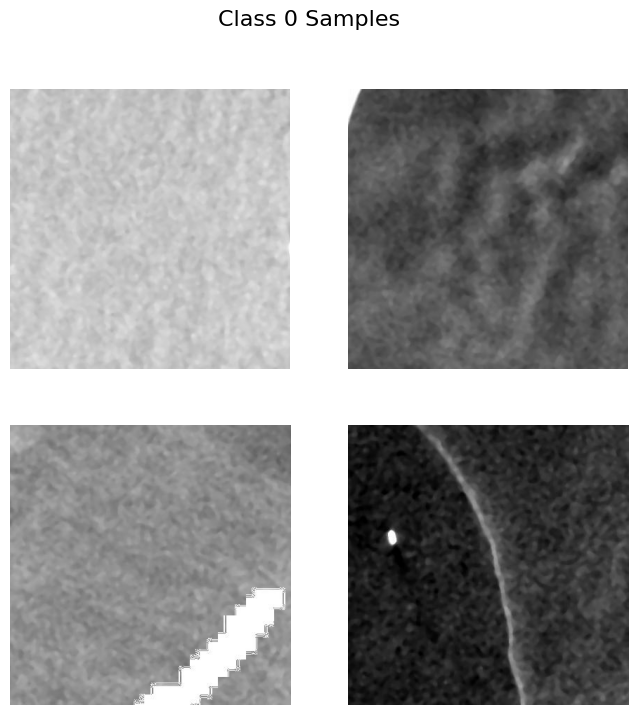

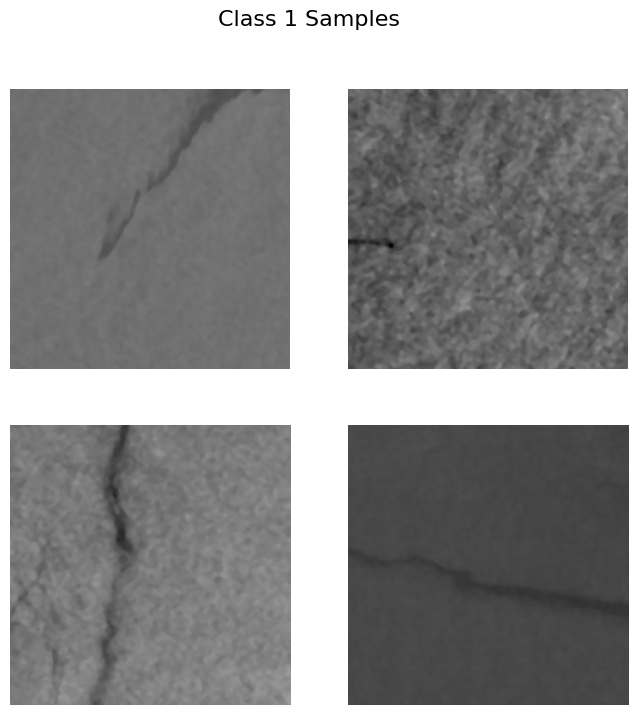

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import random, os

def show_samples(folder, title):
    files = os.listdir(folder)
    files = [f for f in files if f.lower().endswith((".jpg",".png",".jpeg"))]
    sample = random.sample(files, 4)

    plt.figure(figsize=(8,8))
    plt.suptitle(title, fontsize=16)
    for i, fname in enumerate(sample):
        img = Image.open(os.path.join(folder, fname))
        plt.subplot(2,2,i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.show()

show_samples("/content/data/Class0", "Class 0 Samples")
show_samples("/content/data/Class1", "Class 1 Samples")

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

# -----------------------------------------
# Dataset Mapping for understanding contributed by @Shriram S
# -----------------------------------------
class SARImageDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        for label, cls in enumerate(["Class0", "Class1"]):
            folder = os.path.join(root_dir, cls)
            files = os.listdir(folder)
            files = [f for f in files if f.lower().endswith((".jpg",".png",".jpeg"))]
            for f in files:
                self.samples.append((os.path.join(folder, f), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("L")
        img = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0) / 255.0
        return img, label


# -----------------------------------------
# Load dataset
# -----------------------------------------
dataset = SARImageDataset("/content/data")

# Count classes
class0 = sum(1 for _, lbl in dataset.samples if lbl == 0)
class1 = sum(1 for _, lbl in dataset.samples if lbl == 1)

print("Class0:", class0)
print("Class1:", class1)

# -----------------------------------------
# Compute class weights
# -----------------------------------------
total = class0 + class1
weight0 = total / class0
weight1 = total / class1

class_weights = torch.tensor([weight0, weight1], dtype=torch.float32)

print("Class weights:", class_weights)

# -----------------------------------------
# Loss function with weights
# -----------------------------------------
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


Class0: 3725
Class1: 1905
Class weights: tensor([1.5114, 2.9554])


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [5]:
class SARImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for label, cls in enumerate(["Class0", "Class1"]):
            folder = os.path.join(root_dir, cls)
            files = os.listdir(folder)
            files = [f for f in files if f.lower().endswith((".jpg",".png",".jpeg"))]
            for f in files:
                self.samples.append((os.path.join(folder, f), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("L")  # grayscale
        img = img.resize((224, 224))

        img = np.array(img, dtype=np.float32)
        img = np.expand_dims(img, axis=0)
        img /= 255.0

        return torch.tensor(img), torch.tensor(label, dtype=torch.long)


In [6]:
dataset = SARImageDataset("/content/data")

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(dataset, batch_size=32, shuffle=False)

In [7]:
class OilSpillCNN(nn.Module):
    def __init__(self):
        super(OilSpillCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 128), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.net(x)

model = OilSpillCNN().to("cuda")


In [8]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to("cuda"))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [10]:
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to("cuda"), labels.to("cuda")

        optimizer.zero_grad()
        outputs = model(imgs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f} | Acc: {correct/total:.3f}")


Epoch 1/20 | Loss: 0.5309 | Acc: 0.744
Epoch 2/20 | Loss: 0.5108 | Acc: 0.754
Epoch 3/20 | Loss: 0.5013 | Acc: 0.763
Epoch 4/20 | Loss: 0.4908 | Acc: 0.763
Epoch 5/20 | Loss: 0.4713 | Acc: 0.772
Epoch 6/20 | Loss: 0.4609 | Acc: 0.779
Epoch 7/20 | Loss: 0.4460 | Acc: 0.795
Epoch 8/20 | Loss: 0.4232 | Acc: 0.807
Epoch 9/20 | Loss: 0.4007 | Acc: 0.817
Epoch 10/20 | Loss: 0.3934 | Acc: 0.815
Epoch 11/20 | Loss: 0.3835 | Acc: 0.827
Epoch 12/20 | Loss: 0.3720 | Acc: 0.831
Epoch 13/20 | Loss: 0.3550 | Acc: 0.844
Epoch 14/20 | Loss: 0.3411 | Acc: 0.845
Epoch 15/20 | Loss: 0.3310 | Acc: 0.850
Epoch 16/20 | Loss: 0.3186 | Acc: 0.856
Epoch 17/20 | Loss: 0.3161 | Acc: 0.859
Epoch 18/20 | Loss: 0.3126 | Acc: 0.855
Epoch 19/20 | Loss: 0.2856 | Acc: 0.870
Epoch 20/20 | Loss: 0.2873 | Acc: 0.875


🔍 Testing Class 0 (No Oil Spill)


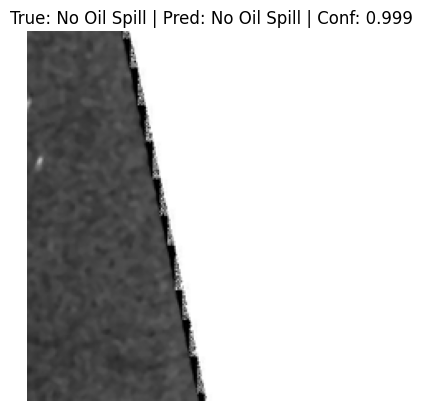

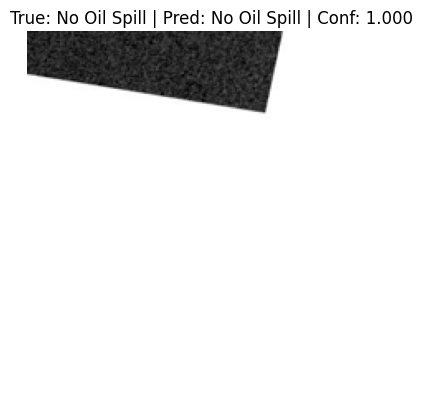

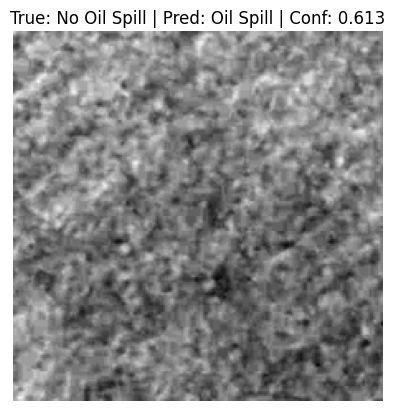

🔍 Testing Class 1 (Oil Spill)


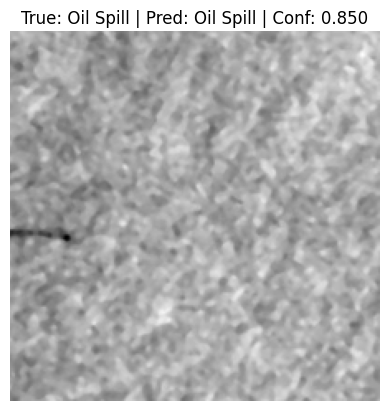

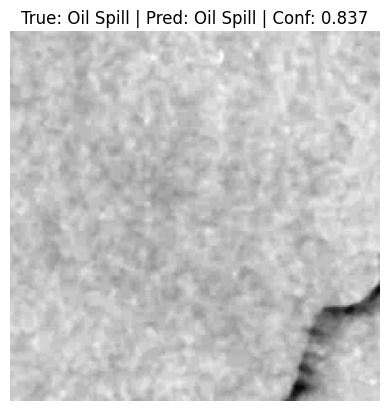

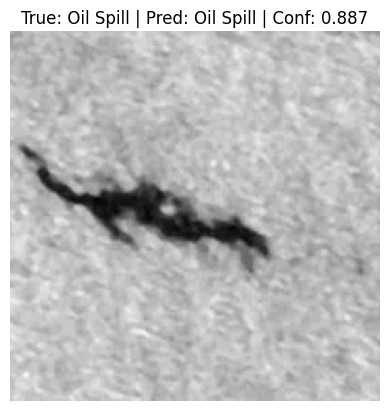

In [14]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

def test_random_image(class_folder, true_label_name):
    files = os.listdir(class_folder)
    files = [f for f in files if f.lower().endswith((".jpg",".jpeg",".png"))]
    img_name = random.choice(files)
    img_path = os.path.join(class_folder, img_name)

    # Load & preprocess
    img = Image.open(img_path).convert("L").resize((224, 224))
    arr = np.expand_dims(np.array(img, dtype=np.float32), axis=0) / 255.0
    arr = np.expand_dims(arr, 0)  # (1,1,224,224)

    tensor = torch.tensor(arr).to("cuda")

    model.eval()
    with torch.no_grad():
        logits = model(tensor)
        prob = F.softmax(logits, dim=1)[0]
        pred_class = torch.argmax(prob).item()
        conf = prob[pred_class].item()

    pred_name = "Oil Spill" if pred_class == 1 else "No Oil Spill"

    # Show image & results
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"True: {true_label_name} | Pred: {pred_name} | Conf: {conf:.3f}")
    plt.show()


# --------------------------------------------
# TEST 3 RANDOM CLASS 0 (No Spill) IMAGES Contributed by @Kanishkar
# --------------------------------------------
print("🔍 Testing Class 0 (No Oil Spill)")
for _ in range(3):
    test_random_image("/content/data/Class0", "No Oil Spill")

# --------------------------------------------
# TEST 3 RANDOM CLASS 1 (Oil Spill) IMAGES
# --------------------------------------------
print("🔍 Testing Class 1 (Oil Spill)")
for _ in range(3):
    test_random_image("/content/data/Class1", "Oil Spill")


In [15]:
import torch
# Saving model as of date 26/11/26 by @Sri Varshan
# Save full model
torch.save(model.state_dict(), "oilspill_model_weights.pth")

# Optionally save complete model architecture + weights
torch.save(model, "oilspill_model_full.pth")

print("Model saved!")


Model saved!
